# Imports and set up

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

from IPython.display import display

import sqlite3

In [166]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
PATH = 'mental_health.sqlite'
connection = sqlite3.connect(PATH)

### Self written helper functions

In [168]:
from myhelpers import PandasHelpers, SeabornHelpers, PandasSeriesAppliers

explore_df = PandasHelpers.explore_df
full_display_rows = PandasHelpers.full_display_rows

kde_boxen = SeabornHelpers.kde_boxen

# Explore and get the data

In [169]:
tables_query = '''
--sql
SELECT * FROM sqlite_schema;
'''

In [170]:
tables = pd.read_sql(tables_query, connection)
# Without .head() since we expect it to be small
tables

,type,name,tbl_name,rootpage,sql
0,table,Answer,Answer,2,"CREATE TABLE ""Answer"" (\n\t""AnswerText"" VARCHA..."
1,table,Question,Question,1434,"CREATE TABLE ""Question"" (\n\t""questiontext"" VA..."
2,table,Survey,Survey,1438,"CREATE TABLE ""Survey"" (\n\t""SurveyID"" INTEGER ..."


It looks like we have several surveys with questions and respondents answers.

In [171]:
for table in tables.name:

    query = f'''
    --sql
    SELECT COUNT(*) size
    FROM {table};
    '''

    df = pd.read_sql(query, connection)
    print(f'TABLE "{table.upper()}"')
    print(f'SIZE: {int(df.iloc[0])}')

    query = f'''
    --sql
    SELECT * FROM {table}
    LIMIT 5;
    '''

    df = pd.read_sql(query, connection)
    display(df)

TABLE "ANSWER"
SIZE: 236898


,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1


TABLE "QUESTION"
SIZE: 105


,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4
4,Are you self-employed?,5


TABLE "SURVEY"
SIZE: 5


,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


In our case it makes sense to combine the data from "ANSWER" and "QUESTION": we will just create and "question" in "ANSWER" table. Table "SURVEY" is useless. We will also include id columns for easier aggregation.

We could keep it in the database and query it with SQL to gain insights, but our approach is more straightworward. However, it is less efficient, so, for larger database it would be probably better to select some pieces of data that we need for different questions.

In [172]:
query = f'''
--sql
SELECT
    a.AnswerText answer, a.SurveyID year, a.UserID user_id,
    q.questiontext question, q.questionid question_id
FROM answer a
JOIN question q
    ON a.QuestionID = q.questionid;
'''

df = pd.read_sql(query, connection)
cols = ['question', 'answer', 'year', 'question_id', 'user_id']
df = df[cols]

Let's also create a questions table:

In [173]:
query = f'''
--sql
SELECT * FROM question;
'''

questions = pd.read_sql(query, connection).set_index(['questionid'])

In [174]:
explore_df(df)

,question,answer,year,question_id,user_id
0,What is your age?,37,2014,1,1
1,What is your age?,44,2014,1,2
2,What is your age?,32,2014,1,3
3,What is your age?,31,2014,1,4
4,What is your age?,31,2014,1,5
236893,Which of the following best describes your wor...,Other,2016,117,2689
236894,Which of the following best describes your wor...,Support,2016,117,2690
236895,Which of the following best describes your wor...,Back-end Developer,2016,117,2691
236896,Which of the following best describes your wor...,DevOps/SysAdmin,2016,117,2692
236897,Which of the following best describes your wor...,Other,2016,117,2693


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236898 entries, 0 to 236897
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   question     236898 non-null  object
 1   answer       236898 non-null  object
 2   year         236898 non-null  int64 
 3   question_id  236898 non-null  int64 
 4   user_id      236898 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 9.0+ MB


None

In [175]:
explore_df(questions)

,questiontext
questionid,
1,What is your age?
2,What is your gender?
3,What country do you live in?
4,"If you live in the United States, which state ..."
5,Are you self-employed?
114,Do you think that team members/co-workers woul...
115,"If yes, what condition(s) have you been diagno..."
116,"If maybe, what condition(s) do you believe you..."
117,Which of the following best describes your wor...


<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 1 to 118
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   questiontext  105 non-null    object
dtypes: object(1)
memory usage: 1.6+ KB


None

It's a little bit strange, that the last id is 118, when we have only 105 questions...

# Preprocess the data

### Classify the questions

We have a plenty of questions (> 100) and some of them have numeric answers, and some are text data... It's too time=consuming to dive into these questions by hands, so we will classify these 2 types of questions automatically and created 2 answer columns instead of 1.

In [176]:
is_num_mask = df.answer.apply(np.char.isnumeric)
df['answer_num'] = df.answer[is_num_mask].astype('Int64')
df['answer_text'] = df.answer[~is_num_mask].str.capitalize()
del df['answer']

Each question can have only numerical answers or only text answers. Let's check it:

In [177]:
answers_count = df[['question_id', 'answer_num', 'answer_text', 'question']].groupby('question_id').count()
answers_count.head()

,answer_num,answer_text,question
question_id,,,
1,4212,6,4218
2,1,4217,4218
3,0,4218,4218
4,0,4218,4218
5,4200,18,4218


Here are some questions, which have both numeric and text answers. Most likely, these answers are wrong:

In [178]:
strange_answers = answers_count[answers_count.answer_num.astype('bool') & answers_count.answer_text.astype('bool')]
strange_answers

,answer_num,answer_text,question
question_id,,,
1,4212,6,4218
2,1,4217,4218
5,4200,18,4218
9,3714,504,4218
13,1571,1387,2958
20,504,2454,2958
58,1308,217,1525
60,1304,221,1525
61,1,1524,1525


We will delete "wrong" rows where these rows are less than 1 % from number of the other answers. Sometimes there is a much less significant difference between the types of questions, we will deal with this issue later.

In [179]:
min_max = strange_answers.apply(lambda row: sorted([row.answer_num, row.answer_text]), axis='columns')
mask = min_max.apply(lambda row: row[0] < row[1] * 0.01)
to_delete = strange_answers[mask][['answer_num', 'answer_text']].idxmin(axis='columns')

In [180]:
full_display_rows(to_delete, n = len(to_delete))

1	answer_text
2	answer_num
5	answer_text
61	answer_num
63	answer_num
71	answer_num
73	answer_num
78	answer_text
81	answer_text
85	answer_text
86	answer_num
88	answer_text


In [181]:
mask = min_max.apply(lambda row: row[0] >= row[1] * 0.01)
num_text_answers = strange_answers[mask]
num_text_answers.join(questions.loc[num_text_answers.index])

,answer_num,answer_text,question,questiontext
question_id,,,,
9,3714,504,4218,Is your employer primarily a tech company/orga...
13,1571,1387,2958,Is your primary role within your company relat...
20,504,2454,2958,Do you have medical coverage (private insuranc...
58,1308,217,1525,Have you ever discussed your mental health wit...
60,1304,221,1525,Have you ever discussed your mental health wit...
62,1302,223,1525,Have you ever had a coworker discuss their or ...
64,1308,217,1525,"Overall, how much importance does your employe..."
65,1308,217,1525,"Overall, how much importance does your employe..."
68,1326,199,1525,Was your employer primarily a tech company/org...


In [182]:
num_text_df = df.query('question_id in @num_text_answers.index')

There are many yes/no questions. But why the answer is often numeric? Let's see:

In [183]:
explore_df(num_text_df[num_text_df.question_id == 9])

,question,year,question_id,user_id,answer_num,answer_text
10080,Is your employer primarily a tech company/orga...,2014,9,1,1,NaN
10081,Is your employer primarily a tech company/orga...,2014,9,2,0,NaN
10082,Is your employer primarily a tech company/orga...,2014,9,3,1,NaN
10083,Is your employer primarily a tech company/orga...,2014,9,4,1,NaN
10084,Is your employer primarily a tech company/orga...,2014,9,5,1,NaN
206752,Is your employer primarily a tech company/orga...,2019,9,4214,0,NaN
206753,Is your employer primarily a tech company/orga...,2019,9,4215,<NA>,-1
206754,Is your employer primarily a tech company/orga...,2019,9,4216,<NA>,-1
206755,Is your employer primarily a tech company/orga...,2019,9,4217,1,NaN
206756,Is your employer primarily a tech company/orga...,2019,9,4218,1,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4218 entries, 10080 to 206756
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question     4218 non-null   object
 1   year         4218 non-null   int64 
 2   question_id  4218 non-null   int64 
 3   user_id      4218 non-null   int64 
 4   answer_num   3714 non-null   Int64 
 5   answer_text  504 non-null    object
dtypes: Int64(1), int64(3), object(2)
memory usage: 234.8+ KB


None

Most likely, in such questions 1 means YES, -1 menas NO  and 0 means something neutral or not recorded. Let's create a columns for these categorical answers. However, here are some other possible answers:

In [184]:
print(num_text_df[num_text_df.question_id == 80]['answer_num'].value_counts())

3     15
4     13
2      9
6      5
7      4
1      4
8      4
0      3
10     2
5      1
Name: answer_num, dtype: Int64


It's difficult to interprete so in this analysis we will just ignore this data:

In [185]:
def is_answer_categorical(row):

    if not pd.isna(row.answer_num):
        if row.answer_num == 1 or row.answer_num == 0:
            return True
    elif not pd.isna(row.answer_text):
        if row.answer_text == -1:
            return True
    
    return False

In [186]:
num_text_df = num_text_df[num_text_df.apply(is_answer_categorical, axis='columns')]

In [187]:
num_text_df = df.query('question_id in @num_text_answers.index')
num_text_df = num_text_df[num_text_df.apply(is_answer_categorical, axis='columns')]
num_text_df.head()

,question,year,question_id,user_id,answer_num,answer_text
10080,Is your employer primarily a tech company/orga...,2014,9,1,1,NaN
10081,Is your employer primarily a tech company/orga...,2014,9,2,0,NaN
10082,Is your employer primarily a tech company/orga...,2014,9,3,1,NaN
10083,Is your employer primarily a tech company/orga...,2014,9,4,1,NaN
10084,Is your employer primarily a tech company/orga...,2014,9,5,1,NaN


In [188]:
def num_to_cat(row):
    if row.answer_num == 1:
        return 'Yes'
    elif row.answer_num == -1:
        return 'No'
    elif row.answer_num == 0:
        return 'Neutral answer'
    else:
        raise ValueError(f'Value {row.answer_num} is not 1, -1 or 0!')

In [189]:
num_text_df['answer_cat'] = num_text_df.apply(num_to_cat, axis='columns')
num_text_df.head()

,question,year,question_id,user_id,answer_num,answer_text,answer_cat
10080,Is your employer primarily a tech company/orga...,2014,9,1,1,NaN,Yes
10081,Is your employer primarily a tech company/orga...,2014,9,2,0,NaN,Neutral answer
10082,Is your employer primarily a tech company/orga...,2014,9,3,1,NaN,Yes
10083,Is your employer primarily a tech company/orga...,2014,9,4,1,NaN,Yes
10084,Is your employer primarily a tech company/orga...,2014,9,5,1,NaN,Yes


In [190]:
cleaned_df = df.join(num_text_df[['answer_cat']], how='left')
cleaned_df['answer_cat'] = cleaned_df['answer_cat'].astype('category')
explore_df(cleaned_df)

,question,year,question_id,user_id,answer_num,answer_text,answer_cat
0,What is your age?,2014,1,1,37,NaN,NaN
1,What is your age?,2014,1,2,44,NaN,NaN
2,What is your age?,2014,1,3,32,NaN,NaN
3,What is your age?,2014,1,4,31,NaN,NaN
4,What is your age?,2014,1,5,31,NaN,NaN
236893,Which of the following best describes your wor...,2016,117,2689,<NA>,Other,NaN
236894,Which of the following best describes your wor...,2016,117,2690,<NA>,Support,NaN
236895,Which of the following best describes your wor...,2016,117,2691,<NA>,Back-end developer,NaN
236896,Which of the following best describes your wor...,2016,117,2692,<NA>,Devops/sysadmin,NaN
236897,Which of the following best describes your wor...,2016,117,2693,<NA>,Other,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236898 entries, 0 to 236897
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   question     236898 non-null  object  
 1   year         236898 non-null  int64   
 2   question_id  236898 non-null  int64   
 3   user_id      236898 non-null  int64   
 4   answer_num   42190 non-null   Int64   
 5   answer_text  194708 non-null  object  
 6   answer_cat   15840 non-null   category
dtypes: Int64(1), category(1), int64(3), object(2)
memory usage: 11.3+ MB


None

# Define analysis objectives

We have many questions and answers, but we are too lazy to explore them all... So, we will just explore descriptive data about the respondents to check is the survey representative and investigate just one aspect of the mental health.

In [191]:
full_display_rows(questions.questiontext, n = len(questions))

1	What is your age?
2	What is your gender?
3	What country do you live in?
4	If you live in the United States, which state or territory do you live in?
5	Are you self-employed?
6	Do you have a family history of mental illness?
7	Have you ever sought treatment for a mental health disorder from a mental health professional?
8	How many employees does your company or organization have?
9	Is your employer primarily a tech company/organization?
10	Does your employer provide mental health benefits as part of healthcare coverage?
11	Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
12	Would you bring up a mental health issue with a potential employer in an interview?
13	Is your primary role within your company related to tech/IT?
14	Do you know the options for mental health care available under your employer-provided health coverage?
15	Has your employer ever formally discussed mental health (for exampl

Personally for me it's interesting to know, how working remotely affects mental health and I will try to gain some insights on this topic from the data. It's important to mention, that we will only understand some correlations, not causations!

So, our objectives are:
1) Check is the sample representative (questions 1, 2, 3, 4, 89), describe the data
2) Try to understand the relation between remote work and mental health (questions 93, 118, 32, 33, 34, 54, 55)
3) Select relevant most similar to the author of this analysis group of responders and answer question 2 from this subset

# Check is the sample representative

Let us firstly create a table to store the information about the responders to store the indormation we are qoing to collect from answers:

In [192]:
respondents = cleaned_df.groupby('user_id').count()[['answer_num', 'answer_text', 'answer_cat']]
explore_df(respondents)

,answer_num,answer_text,answer_cat
user_id,,,
1,3,23,1
2,3,23,1
3,3,23,1
4,3,23,1
5,3,23,1
4214,21,55,10
4215,15,61,6
4216,9,67,1
4217,21,55,9


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4218 entries, 1 to 4218
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   answer_num   4218 non-null   int64
 1   answer_text  4218 non-null   int64
 2   answer_cat   4218 non-null   int64
dtypes: int64(3)
memory usage: 131.8 KB


None

### Age

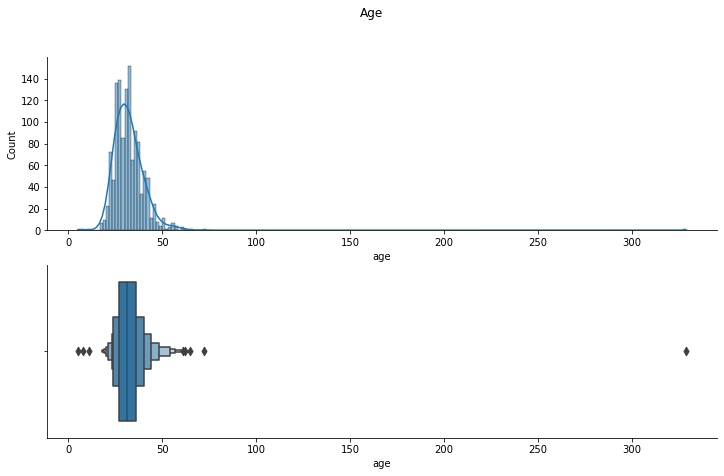

In [193]:
respondents['age'] = cleaned_df[cleaned_df.question_id == 1].answer_num

kde_boxen(respondents, 'age', figsize=(12, 7))

Let us remove outliers:

In [194]:
respondents.drop(respondents.age[(respondents.age > 100) | (respondents.age < 18)].index, inplace=True)

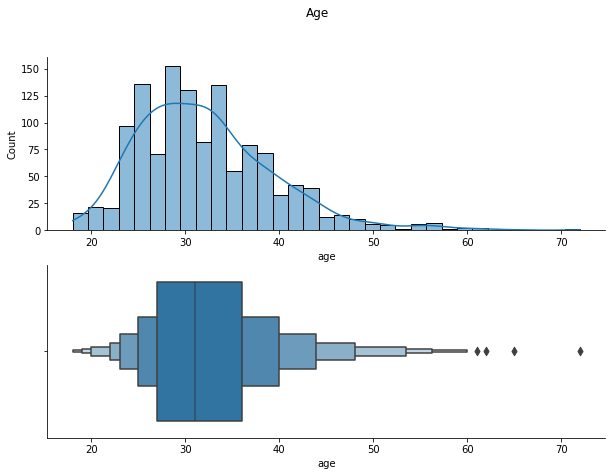

In [195]:
kde_boxen(respondents, 'age', figsize=(10, 7))

Now it is better! Actual distribution is slightly right skewed, centered about +- 30. That is ok. Comparing with overall tech industry, it's quite small average age (it is about 38). Probably, the sample is biased.

### Gender

In [196]:
gender_df = cleaned_df[cleaned_df.question_id == 2][['answer_text', 'user_id']]
gender_df.rename({'answer_text': 'gender'}, axis='columns', inplace=True)
gender_df.set_index('user_id', inplace=True)
gender_df.head()

,gender
user_id,
1,Female
2,Male
3,Male
4,Male
5,Male


In [197]:
print(gender_df.gender.unique())

['Female' 'Male' 'Male-ish' 'Trans-female' 'Something kinda male?'
 'Queer/she/they' 'Non-binary' 'Nah' 'All' 'Enby' 'Fluid' 'Genderqueer'
 'Androgyne' 'Agender' 'Guy (-ish) ^_^' 'Male leaning androgynous'
 'Trans woman' 'Neuter' 'Female (trans)' 'Queer' 'A little about you' 'P'
 'Ostensibly male, unsure what that really means' 'Bigender'
 'Female assigned at birth' 'Fm' 'Transitioned, m2f'
 'Genderfluid (born female)' 'Other/transfeminine'
 'Female or multi-gender femme' 'Androgynous' 'Male 9:1 female, roughly'
 '-1' 'Other' 'Nb masculine' 'None of your business' 'Human' 'Genderfluid'
 'Genderqueer woman' 'Mtf' 'Male/genderqueer' 'Nonbinary' 'Unicorn'
 'Male (trans, ftm)' 'Genderflux demi-girl'
 'Female-bodied; no feelings about gender' 'Afab' 'Transgender woman'
 'Male/androgynous' 'Uhhhhhhhhh fem genderqueer?'
 'God king of the valajar' 'Agender/genderfluid' 'Sometimes'
 'Woman-identified' 'Contextual' 'Non binary' 'Genderqueer demigirl'
 'Genderqueer/non-binary' 'Female-ish' '\\-' 

In [198]:
trans_variants = []
nonbin_variants = []

for variant in gender_df.gender.unique():
    try:
        if 'binary' in variant.lower():
            print(f'NONBINARY: {variant}')
            nonbin_variants.append(variant)
        elif 'trans' in variant.lower():
            print(f'TRANS: {variant}')
            trans_variants.append(variant)
    except AttributeError:
        continue

TRANS: Trans-female
NONBINARY: Non-binary
TRANS: Trans woman
TRANS: Female (trans)
TRANS: Transitioned, m2f
TRANS: Other/transfeminine
NONBINARY: Nonbinary
TRANS: Male (trans, ftm)
TRANS: Transgender woman
NONBINARY: Non binary
NONBINARY: Genderqueer/non-binary
TRANS: Transfeminine
TRANS: Trans man
TRANS: Transgender
NONBINARY: Female/gender non-binary.
TRANS: Trans female
NONBINARY: Nonbinary/femme
TRANS: Agender trans woman
NONBINARY: Trans non-binary/genderfluid
NONBINARY: Non-binary and gender fluid


Wow, such a diversity!

In [199]:
gender_df.gender.value_counts().head(10)

Male           3043
Female         1024
-1               24
Nonbinary         9
Non-binary        9
Agender           6
Genderqueer       5
Genderfluid       4
None              4
Non binary        3
Name: gender, dtype: int64

Let's clean this data a little bit to analyze as just category:

In [200]:
multi_replace = PandasSeriesAppliers.multi_replace

mapper = {
    'Male': ['Male'],
    'Female': ['Female'],
    'Transgender': trans_variants,
    'Nonbinary': nonbin_variants,
    'Not recorded': ['-1']
}

gender_df['gender'] = gender_df.gender.apply(multi_replace, mapper=mapper, default='Other')

In [201]:
respondents = respondents.join(gender_df)
respondents.head()

,answer_num,answer_text,answer_cat,age,gender
user_id,,,,,
1,3,23,1,44,Female
2,3,23,1,32,Male
3,3,23,1,31,Male
4,3,23,1,31,Male
5,3,23,1,33,Male


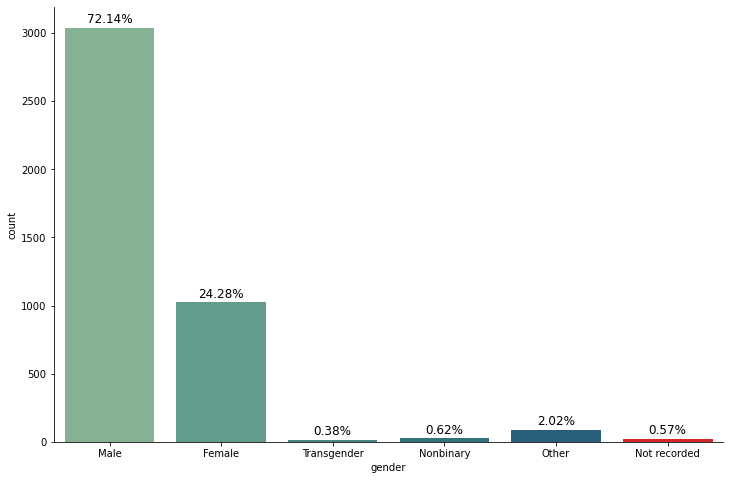

In [202]:
# TODO To helpers

sns_red = sns.color_palette()[3]

plt.figure(figsize=(12, 8))
ax = sns.countplot(
    data=respondents, x='gender',
    # Ability to order by smth, but "throw out" some marked columns like "Not recorded"
    order=('Male', 'Female', 'Transgender', 'Nonbinary', 'Other', 'Not recorded'),
    palette='crest'
)
# 
bars = ax.containers[0]
# Not by index, but by name also (i. e. x value)
bars[-1].set_color(sns_red)

# Annotate
labels = [f'{bar.get_height() / len(respondents):.2%}' for bar in bars]
ax.bar_label(bars, labels, padding=2, fontsize=12)

sns.despine()
plt.show()

These numbers are quite close to known data (google says, that 24% of tech jobs are held by women)

### Country

In [203]:
country_df = cleaned_df[cleaned_df.question_id == 3][['answer_text', 'user_id']]
country_df.rename({'answer_text': 'country'}, axis='columns', inplace=True)
country_df.set_index('user_id', inplace=True)
country_df.head()

,country
user_id,
1,United states
2,United states
3,Canada
4,United kingdom
5,United states


In [204]:
print(country_df.value_counts())

country                 
United states of america    1853
United states                751
United kingdom               482
Canada                       199
Germany                      136
                            ... 
Jordan                         1
Kenya                          1
Philippines                    1
Macedonia                      1
Zimbabwe                       1
Length: 81, dtype: int64


Both 2 first rows are USA actually:

In [205]:
country_df['country'] = country_df.country.apply(multi_replace, mapper={
    'USA': ['United states of america', 'United states']
})

respondents = respondents.join(country_df)
respondents.head()

,answer_num,answer_text,answer_cat,age,gender,country
user_id,,,,,,
1,3,23,1,44,Female,USA
2,3,23,1,32,Male,USA
3,3,23,1,31,Male,Canada
4,3,23,1,31,Male,United kingdom
5,3,23,1,33,Male,USA


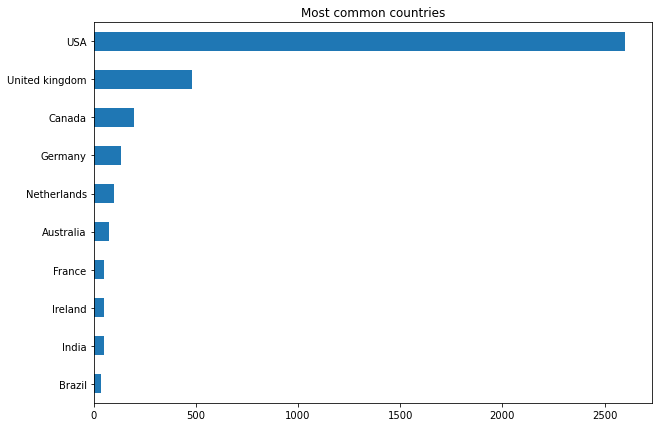

In [206]:
plt.figure(figsize=(10, 7))

respondents.country.value_counts()[:10][::-1].plot.barh()
plt.title('Most common countries')
plt.show()

### Race

In [207]:
race_df = cleaned_df[cleaned_df.question_id == 89][['answer_text', 'user_id']]
race_df.rename({'answer_text': 'race'}, axis='columns', inplace=True)
race_df.set_index('user_id', inplace=True)
race_df.head()

,race
user_id,
2694,-1
2695,-1
2696,White
2697,White
2698,More than one of the above


In [208]:
print(race_df.value_counts())

race                            
White                               873
-1                                  537
More than one of the above           35
Asian                                31
I prefer not to answer               29
Black or african american            15
American indian or alaska native      1
Caucasian                             1
European american                     1
Hispanic                              1
White hispanic                        1
dtype: int64


In [209]:
mapper = {
    'White': ['White'],
    'Asian': ['Asian'],
    'Black': ['Black or african american'],
    'No answer': ['I prefer not to answer'],
    'Not recorded': ['-1']
}

race_df['race'] = race_df.race.apply(multi_replace, mapper=mapper, default='Other')

In [210]:
respondents = respondents.join(race_df)
respondents.head()

,answer_num,answer_text,answer_cat,age,gender,country,race
user_id,,,,,,,
1,3,23,1,44,Female,USA,NaN
2,3,23,1,32,Male,USA,NaN
3,3,23,1,31,Male,Canada,NaN
4,3,23,1,31,Male,United kingdom,NaN
5,3,23,1,33,Male,USA,NaN


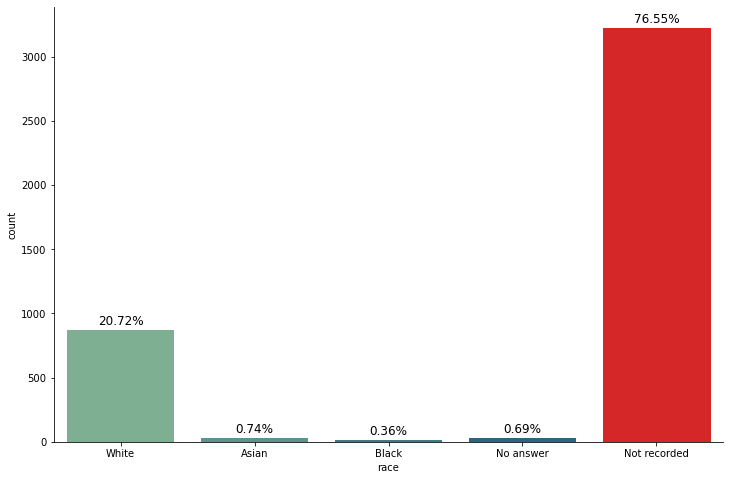

In [211]:
respondents['race'] = respondents.race.fillna('Not recorded')

# TODO To helpers

sns_red = sns.color_palette()[3]

plt.figure(figsize=(12, 8))
ax = sns.countplot(
    data=respondents, x='race',
    # Ability to order by smth, but "throw out" some marked columns like "Not recorded"
    order=('White', 'Asian', 'Black', 'No answer', 'Not recorded'),
    palette='crest'
)
# 
bars = ax.containers[0]
# Not by index, but by name also (i. e. x value)
bars[-1].set_color(sns_red)

# Annotate
labels = [f'{bar.get_height() / len(respondents):.2%}' for bar in bars]
ax.bar_label(bars, labels, padding=2, fontsize=12)

sns.despine()
plt.show()

There is no much data about the race...

### Age and gender

Let's just compare the age distributions for 2 major genders:

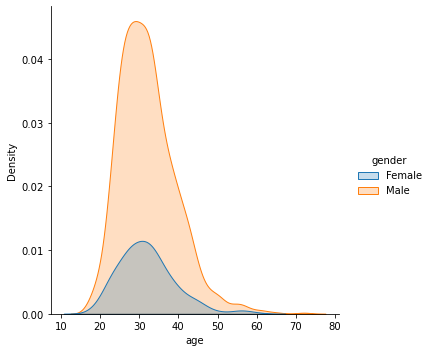

In [212]:
sns.displot(data=respondents.query('gender in ["Male", "Female"]'), x='age', hue='gender', kind='kde', fill=True)

sns.despine()
plt.show()

Well, these distributions are quite similar. It turns out that tech industry differs from the entire population in this apsect.

### Final respondents data

In [236]:
explore_df(respondents)

,answer_num,answer_text,answer_cat,age,gender,country,race
user_id,,,,,,,
1,3,23,1,44,Female,USA,Not recorded
2,3,23,1,32,Male,USA,Not recorded
3,3,23,1,31,Male,Canada,Not recorded
4,3,23,1,31,Male,United kingdom,Not recorded
5,3,23,1,33,Male,USA,Not recorded
4214,21,55,10,<NA>,Male,India,Not recorded
4215,15,61,6,<NA>,Male,USA,White
4216,9,67,1,<NA>,Male,India,Not recorded
4217,21,55,9,<NA>,Female,India,Not recorded


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4214 entries, 1 to 4218
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   answer_num   4214 non-null   int64 
 1   answer_text  4214 non-null   int64 
 2   answer_cat   4214 non-null   int64 
 3   age          1251 non-null   Int64 
 4   gender       4214 non-null   object
 5   country      4214 non-null   object
 6   race         4214 non-null   object
dtypes: Int64(1), int64(3), object(3)
memory usage: 396.5+ KB


None

Here are some problems with collecting age and race data... It's also important to mention, that at least all the respondents are from US.

In general, this sample is quite biased.

# Mental health and remote work

### Select questions

In [213]:
full_display_rows(questions.loc[[32, 33, 34, 54, 55]].questiontext)

32	Have you had a mental health disorder in the past?
33	Do you currently have a mental health disorder?
34	Have you ever been diagnosed with a mental health disorder?
54	Do you believe your productivity is ever affected by a mental health issue?
55	If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?


In [235]:
respondents.iloc[1261]

answer_num                  5
answer_text                61
answer_cat                  1
age                      <NA>
gender                   Male
country        United kingdom
race             Not recorded
Name: 1266, dtype: object

In [214]:
research_df = respondents[['age', 'gender', 'country', 'race']]
research_df.reset_index()

to_merge = cleaned_df[cleaned_df.question_id == 118][['user_id', 'answer_text']].rename(columns={'answer_text': 'working_remotely'})
research_df = research_df.merge(to_merge, on='user_id')

to_merge = cleaned_df[cleaned_df.question_id == 33][['user_id', 'answer_text']].rename(columns={'answer_text': 'mental_disorder'})
research_df = research_df.merge(to_merge, on='user_id')

research_df.head()

,user_id,age,gender,country,race,working_remotely,mental_disorder
0,1261,<NA>,Male,United kingdom,Not recorded,Sometimes,No
1,1262,<NA>,Male,USA,Not recorded,Never,Yes
2,1263,<NA>,Male,United kingdom,Not recorded,Always,No
3,1264,<NA>,Male,United kingdom,Not recorded,Sometimes,Yes
4,1265,<NA>,Female,USA,Not recorded,Sometimes,Yes


### Ratios of people with mental disorder

In [215]:
ratios = research_df[-(research_df.mental_disorder == 'No')]

In [216]:
ratios

,user_id,age,gender,country,race,working_remotely,mental_disorder
1,1262,<NA>,Male,USA,Not recorded,Never,Yes
3,1264,<NA>,Male,United kingdom,Not recorded,Sometimes,Yes
4,1265,<NA>,Female,USA,Not recorded,Sometimes,Yes
5,1266,<NA>,Male,United kingdom,Not recorded,Sometimes,Yes
7,1268,<NA>,Female,USA,Not recorded,Always,Yes
...,...,...,...,...,...,...,...
1426,2687,<NA>,Female,Canada,Not recorded,Sometimes,Yes
1427,2688,<NA>,Female,USA,Not recorded,Always,Yes
1430,2691,<NA>,Male,USA,Not recorded,Sometimes,Maybe
1431,2692,<NA>,Female,USA,Not recorded,Sometimes,Yes


In [217]:
def order_working_remotely(index_value):
    return ('Never', 'Sometimes', 'Always').index(index_value)

ratios.working_remotely.value_counts().sort_index(key=order_working_remotely)
# WHY IS IT SO???

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

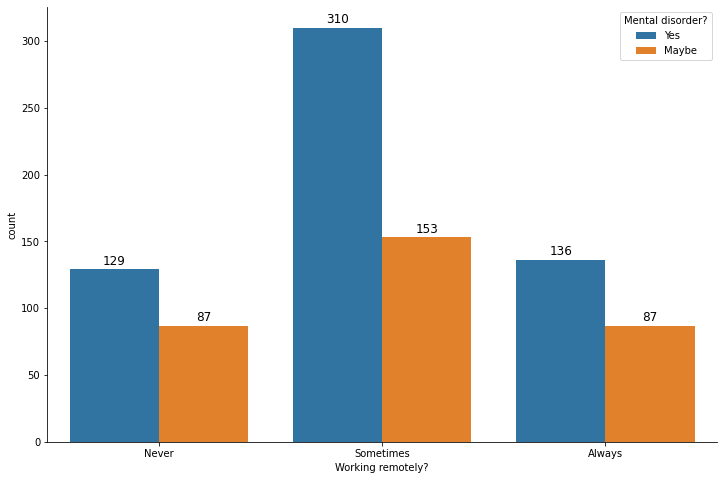

In [218]:
plt.figure(figsize=(12, 8))

ax = sns.countplot(
    data=ratios,
    x='working_remotely', hue='mental_disorder', order=['Never', 'Sometimes', 'Always']
)

for bar_batch in ax.containers:
    ax.bar_label(bar_batch, padding=2, fontsize=12)


plt.xlabel('Working remotely?')
ax.legend(title='Mental disorder?')

sns.despine()
plt.show()

It looks like hybrid working is correlated with mental disorder... But let's run a linear model to check it.

### Convert categorical data to numbers and normalize

In [219]:
cat_to_num = PandasSeriesAppliers.cat_to_num

col_names = ['gender', 'country', 'working_remotely', 'mental_disorder']
research_df_num = research_df.copy()[col_names]

for col_name in ('gender', 'country', 'working_remotely', 'mental_disorder'):
    if col_name == 'mental_disorder':
        order = ('No', 'Maybe', 'Yes')
    else:
        order = tuple(research_df[col_name].unique())
    research_df_num[col_name] = research_df[col_name].apply(cat_to_num, order=order)

### Just correlations

In [220]:
research_df_num.corr()

,gender,country,working_remotely,mental_disorder
gender,1.000000,-0.100584,0.032525,0.188606
country,-0.100584,1.000000,0.019033,-0.095457
working_remotely,0.032525,0.019033,1.000000,0.012215
mental_disorder,0.188606,-0.095457,0.012215,1.000000


Nothing is shown...

### Regression model

In [240]:
predictors = ['gender', 'country', 'working_remotely']
x = np.array(research_df_num[predictors])
y = np.array(research_df_num.mental_disorder)

In [241]:
model = LinearRegression().fit(x, y)

In [244]:
print('Linear regression model')
print(f'R\u00b2: {model.score(x, y)}')
for predictor, coefficient in zip(predictors, model.coef_):
    print(f'{predictor}\t{coefficient:.3f}')

Linear regression model
R²: 0.041543037561070695
gender	0.669
country	-0.214
working_remotely	0.008


It turns out that country and especially gender are actually more important factors, affecting the mental health. However, the model is vey bad...

# Possible improvements

- Find some data, collected using probablity sampling, and than use quasi-randomization or population modeling
- Preprocess ALL the answers...
- More complex tegression models: multilevel, Bayesian or others, DAGs
- NLP: for example, sentiment analysis of some answers

# Conclusion

Data cleaning is time-consuming...

But someone can use my code for basic prepocessing, if I will publish it!